# Hate Speech Detection from Tweets (Shallow Methods)

## Import Datasets and Libraries

In [ ]:
!pip3 install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import datasets 
import string
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn import linear_model 
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

from xgboost import XGBClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

## Visualize Data

Load UC Berkley Dataset for measuring hate speech.

In [ ]:
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-7a847a2ec289eb57
Reusing dataset parquet (/Users/rathinvaradharajan/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-7a847a2ec289eb57/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

We are interested in 3 Columns: ["text", "hatespeech", "hate_speech_score"]

Text: The tweet

HateSpeech: Trinary Classification Variable: 0 - No Hate, 1 - Neutral, 2 - Hatred

HateSpeechScore: A continuos variable rangeing from [-8, 6] which gives us the extent of positivity and negativity in tweets.

In [ ]:
train = df[["text", "hatespeech", "hate_speech_score"]].iloc[:30000,] # [:100000]
train.head()

,text,hatespeech,hate_speech_score
0,Yes indeed. She sort of reminds me of the elde...,0.0,-3.90
1,The trans women reading this tweet right now i...,0.0,-6.52
2,Question: These 4 broads who criticize America...,2.0,0.36
3,It is about time for all illegals to go back t...,0.0,0.26
4,For starters bend over the one in pink and kic...,2.0,1.54


Countplot to visualize how the data is classified.

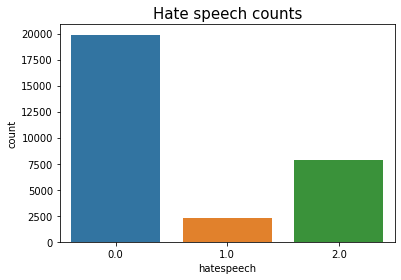

In [ ]:
sns.countplot(train['hatespeech'])
plt.title("Hate speech counts", fontsize = 15)
plt.show()

We notice that the neutral classification doesn't add a lot of value and hence it's removed.

In [ ]:
train = train[train['hatespeech'] != 1.0]

Countplot after removing.

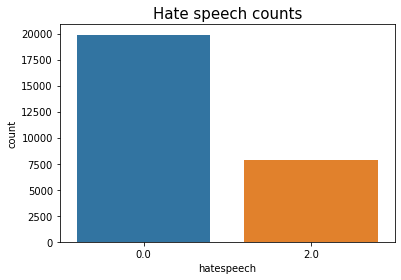

In [ ]:
sns.countplot(train['hatespeech'])
plt.title("Hate speech counts", fontsize = 15)
plt.show()

Visualizing how the hate score is spread using histograms. As expected it is a normal distribuion where only few tweets are at the extreme.

(array([ 115.,  270.,  711., 1463., 2482., 3320., 4065., 5243., 5165.,
        3434., 1137.,  215.,   48.,   12.]),
 array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6]),
 <BarContainer object of 14 artists>)

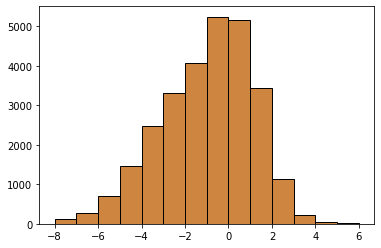

In [ ]:
bins = [-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
plt.hist(train['hate_speech_score'], facecolor='peru', edgecolor='black', bins=bins)

## Pre-Processing the Tweets

Method to pre-process the text using: Lower Casing, Lematization, Stemming, Removing - Links, Stop Words, Punctuations.

In [ ]:
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):
    text = text.lower()
    
    # Remove punctuations
    mod = str.maketrans('','',string.punctuation)
    text = text.translate(mod)
    
    # Remove Links
    text = re.sub(r"http\S+", "", text)
    
    # Remove stop words
    stop_set = set(stopwords.words('english'))
    tokenized_text = word_tokenize(text)
    filtered_text = [word for word in tokenized_text if not word in stop_set]
    
    #Stemming
    cleaned_text = [ps.stem(word) for word in filtered_text]

    return " ".join(cleaned_text)    

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rathinvaradharajan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rathinvaradharajan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rathinvaradharajan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/rathinvaradharajan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rathinvaradharajan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Clean all the tweets

In [ ]:
def clean_tweet(tweets):
  cleaned_tweet = []
  for tweet in tweets:
    cleaned_tweet.append(clean_text(tweet))
  return cleaned_tweet

In [ ]:
clean_dataset = clean_tweet(train["text"])

## Predicting HateSpeech (Classification)

### Naive Bayes

In [ ]:
def naive_bayes(embedding, classifier):
  # Vectorizing the dataset.
  vectorizer = embedding.fit(clean_dataset)
  x_total = vectorizer.transform(clean_dataset)
  # Splitting the data to test and train
  x_train, x_test, y_train, y_test = train_test_split(x_total, train["hatespeech"], test_size=0.20, random_state=5)
  # Fitting the data in model
  classifier.fit(x_train.todense(), y_train)
  # Predicting test set results
  y_pred = classifier.predict(x_test.todense())
  return x_total, x_train, x_test, y_train, y_test, y_pred

### Evaluation Metrics

In [ ]:
def evaluate_model(y_test, y_pred):
  #Calculate the Accuracy, F1 Score, Recall and Precsion
  print(classification_report(y_test, y_pred))
  cnf = confusion_matrix(y_test, y_pred)
  print("Confustion Matrix")
  print(cnf)

### Comparing Vectorizers (Count & TF-IDF Vectorizers)

In [ ]:
print("\nCount Vectorizer and Naive Bayes\n")
x_total_cv, x_train_cv, x_test_cv, y_train_cv, y_test_cv, y_pred_cv = naive_bayes(CountVectorizer(), MultinomialNB())
evaluate_model(y_test_cv, y_pred_cv)

print("\nTfidf Vectorizer and Naive Bayes\n")
x_total_tf, x_train_tf, x_test_tf, y_train_tf, y_test_tf, y_pred_tf = naive_bayes(TfidfVectorizer(), MultinomialNB())
evaluate_model(y_test_tf, y_pred_tf)


Count Vectorizer and Naive Bayes

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84      4018
         2.0       0.59      0.65      0.62      1522

    accuracy                           0.78      5540
   macro avg       0.72      0.74      0.73      5540
weighted avg       0.79      0.78      0.78      5540

Confustion Matrix
[[3323  695]
 [ 532  990]]

Tfidf Vectorizer and Naive Bayes

              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86      4018
         2.0       0.77      0.22      0.34      1522

    accuracy                           0.77      5540
   macro avg       0.77      0.60      0.60      5540
weighted avg       0.77      0.77      0.72      5540

Confustion Matrix
[[3920   98]
 [1188  334]]


Movinng forward we will be using TF-IDf for all models.

In [ ]:
x_total, x_train, x_test, y_train, y_test = x_total_tf, x_train_tf, x_test_tf, y_train_tf, y_test_tf

### Support Vector Machine algorithm for Classification

In [ ]:
# Define model
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# Fit the training dataset on the classifier
SVM.fit(x_train.todense(), y_train)
# Predict the labels on test dataset
y_pred = SVM.predict(x_test.todense())

In [ ]:
print("Support Vector Machine")
evaluate_model(y_test, y_pred)

Support Vector Machine
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88      1353
         2.0       0.76      0.43      0.55       498

    accuracy                           0.81      1851
   macro avg       0.79      0.69      0.72      1851
weighted avg       0.80      0.81      0.79      1851

Confustion Matrix
[[1283   70]
 [ 282  216]]


### Random Forest Algorithm for Classification

In [ ]:
# Define model
rf = RandomForestClassifier(n_estimators=400,criterion="entropy",random_state=0)
# Fit the training dataset on the classifier
rf.fit(x_train.todense(), y_train)
# Predict the labels on test dataset
y_pred = rf.predict(x_test)

In [ ]:
print("Random Forest")
evaluate_model(y_test, y_pred)

Random Forest
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      4018
         2.0       0.72      0.47      0.57      1522

    accuracy                           0.80      5540
   macro avg       0.77      0.70      0.72      5540
weighted avg       0.79      0.80      0.79      5540

Confustion Matrix
[[3734  284]
 [ 802  720]]


### XGBoost Algorthm for Classification

In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
_ = label_encoder.fit([0.0, 2.0])

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
# Define model
xgb = XGBClassifier(loss='log_loss', learning_rate=0.1, n_estimators=300)
# Fit the training dataset on the classifier
xgb.fit(x_train, y_train)
# Predict the labels on test dataset
y_pred = xgb.predict(x_test)

[17:37:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "loss" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
print("XG Boost")
evaluate_model(y_test, y_pred)

XG Boost
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4018
           1       0.75      0.49      0.60      1522

    accuracy                           0.82      5540
   macro avg       0.79      0.72      0.74      5540
weighted avg       0.81      0.82      0.80      5540

Confustion Matrix
[[3766  252]
 [ 770  752]]


## Predicting Hate Speech Score (Regression)

Splitting the dataset into training and testing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_total, train["hate_speech_score"], test_size=0.20, random_state=5)

### Evaluation Metrics

We use Mean Absolute Error and Root Mean Square Error for evaluating the regression models since these are the best metrics to measure performance.

In [ ]:
def evaluate_regression_models(y_pred, y_test):
  mae = metrics.mean_absolute_error(y_pred, y_test)
  rmse =  np.sqrt(metrics.mean_squared_error(y_test,y_pred))
  print("Mean Absolute Error: ", mae)
  print("Root Mean Square Error: ", rmse)


### Lasso Regression

In [ ]:
# Define model
regr = linear_model.Lasso()
# Fit the training dataset on the regressor
regr.fit(x_train, y_train)
# Predict the hatescore
y_pred = regr.predict(x_test)
print("Lasso Regression")
evaluate_regression_models(y_pred, y_test)

Lasso Regression
Mean Absolute Error:  1.7195029317364152
Root Mean Square Error:  2.1129277556914614


We see that Lasso Regresssion is not performing well.

### Stochastic Gradient Descent

In [ ]:
# Define model
regr = linear_model.SGDRegressor()
# Fit the training dataset on the regressor
regr.fit(x_train, y_train)
# Predict the hatescore
y_pred = regr.predict(x_test)
print("Stochastic Gradient Descent")
evaluate_regression_models(y_pred, y_test)

Stochastic Gradient Descent
Mean Absolute Error:  1.1674311409753655
Root Mean Square Error:  1.493223135463569


Stochastic Gradient Descent does better than Lasso and bring down the error significantly.

### Ridge Regression

In [ ]:
# Define model
regr = linear_model.Ridge()
# Fit the training dataset on the regressor
regr.fit(x_train, y_train)
# Predict the hatescore
y_pred = regr.predict(x_test)
print("Ridge Regression")
evaluate_regression_models(y_pred, y_test)

Ridge Regression
Mean Absolute Error:  1.0570302379262142
Root Mean Square Error:  1.3684374592455681


Ridge Performs marginally better than the SGD.

### K Nearest Neighbour (K=10)

In [ ]:
# Define model
model = neighbors.KNeighborsRegressor(n_neighbors = 10)
# Fit the training dataset on the model
model.fit(x_train, y_train) 
# Predict the hatescore 
y_pred=model.predict(x_test)
print("K Nearest Neighbour")
evaluate_regression_models(y_pred, y_test)

K Nearest Neighbour
Mean Absolute Error:  1.2366447653429604
Root Mean Square Error:  1.5914015416566


Aside from the regular regression models, K NN can also be used in predicting the hate speech score. Once the model is trained for each tweet its nearest neighbors are computed and averaged out to find the predicted value. 
K value of 10 is chosen after iterating for multiple values.